# Lab: Exploring Transformers for Natural Language Processing and Vision Tasks

---

## Objective
In this lab, you will:

1. nderstand the basic architecture of the Transformer model (attention mechanism, positional encoding, encoder-decoder structure).
2. Implement a Transformer for an NLP task, such as text classification or machine translation.
3. Apply a Vision Transformer (ViT) for image classification.
4. Reflect on the differences between Transformer architectures for text and for vision.

---

# Part 1: Theoretical Overview

## 1. The Fundamental Components of Transformers

### a. Context and Reference

A summary of the main concepts introduced in the research paper “[Attention Is All You Need](https://arxiv.org/pdf/1706.03762)”.


---

### 2. The Self-Attention Mechanism

#### 2.1 Principle

Self-attention (or “intra-attention”) allows each position in a sequence (word, sub-word, token) to “look at” all other positions in the sequence to extract the most relevant information. Unlike recurrent neural networks (RNNs) that process sequences iteratively, self-attention operates in one matrix step by matching **all** positions with **all** others.

Each token is represented by a vector (embedding) and, to compute attention, three matrices are created: **Q** (Query), **K** (Key), and **V** (Value), each obtained by a linear transformation of the initial embedding.

#### 2.2 Calculation

The basis for calculating the self-attention matrix is the “Scaled Dot-Product Attention”:

$$
\text{Attention}(Q, K, V) = \text{softmax}\!\Bigl(\frac{QK^\top}{\sqrt{d_k}}\Bigr) \, V
$$

- **Q** has dimensions $(n \times d_k)$ for $n$ tokens with a key dimension $d_k$.
- **K** has dimensions $(n \times d_k)$.
- **V** has dimensions $(n \times d_v)$.

Dividing by $\sqrt{d_k}$ stabilizes the gradients by preventing overly large dot products.

#### 2.3 Simplified Example

Assume a sequence of 3 tokens $\{t_1, t_2, t_3\}$. After converting into embeddings, you obtain vectors of dimension $d_{model}$. Each embedding is then projected to obtain $Q$, $K$, and $V$ (for example with $d_k = 2$):

$$
Q = \begin{bmatrix}
q_{11} & q_{12} \\
q_{21} & q_{22} \\
q_{31} & q_{32}
\end{bmatrix}
$$

$$
K = \begin{bmatrix}
k_{11} & k_{12} \\
k_{21} & k_{22} \\
k_{31} & k_{32}
\end{bmatrix}
$$

$$
V = \begin{bmatrix}
v_{11} & v_{12} \\
v_{21} & v_{22} \\
v_{31} & v_{32}
\end{bmatrix}
$$

The product $QK^\top$ results in a $3 \times 3$ matrix. After normalization by $\sqrt{d_k}= \sqrt{2}$ and applying a row-wise softmax, you obtain the attention weights used to combine $V$ linearly.

---

### 3. Multi-Head Attention

#### 3.1 Principle

Instead of using a single attention matrix, the Transformer employs multiple attention heads in parallel (multi-head attention). Each head performs its own self-attention calculation with distinct linear projections, enabling the extraction of various correlations (e.g., syntax, anaphora, long-range dependencies).

#### 3.2 Calculation

For $h$ heads, $h$ self-attention calculations are performed, with matrices $Q$, $K$, and $V$ projected into smaller subspaces. For example, with $d_{model}=512$ and $h=8$, each head works with vectors of size $d_k = \frac{512}{8} = 64$. The outputs of the heads are then concatenated, and a final projection is applied:

$$
\text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, \text{head}_2, \ldots, \text{head}_h) \; W^O,
$$

where

$$
\text{head}_i = \text{Attention}(Q\,W_i^Q,\;K\,W_i^K,\;V\,W_i^V).
$$

The matrices $W_i^Q, W_i^K, W_i^V$ are specific to each head, and $W^O$ performs the final projection.

#### 3.3 Example

With 8 heads, each head operates in a space of dimension 64.
For instance, one head may learn to capture subject-verb dependencies
while another focuses on punctuation or rare words.
Each head outputs a matrix of size `n × d_v`.
After concatenation (resulting in a size `n × (h × d_v)`),
a matrix `W^O` (of size `(h × d_v) × d_model`)
is used to map back to the `d_model` dimension.

---

### 4. Positional Encoding

#### 4.1 The Order Problem

Transformers, lacking convolutions or recurrence, do not have an inherent notion of sequence order. To allow the model to differentiate, for example, a token at the beginning of a sentence from one at the end, positional encoding is added to the embeddings.

#### 4.2 Sine/Cosine Form

The method proposed in the paper uses sinusoids of increasing frequencies:

$$
\text{PE}(pos,\,2i) = \sin\Bigl(\frac{pos}{10000^{\,\frac{2i}{d_{model}}}}\Bigr)
\quad;\quad
\text{PE}(pos,\,2i+1) = \cos\Bigl(\frac{pos}{10000^{\,\frac{2i}{d_{model}}}}\Bigr),
$$

where $pos$ represents the position (0, 1, 2, …) and $i$ is the dimension index. Each dimension of the position vector follows a different sinusoid. These values are then added to the token embedding to create a unique positional signature.

The sinusoids are constructed so that their wavelengths follow a geometric progression, ranging from $2\pi$ to $10000 \cdot 2\pi$. This progression allows each dimension to capture positional information at different scales.

#### 4.3 Role and Benefits of Sinusoidal Encoding

Using sinusoids enables the model to capture relative relationships between tokens. For an offset $k$, the encoding of position $pos + k$ can be expressed as a linear combination of $PE(pos)$. This facilitates relative attention and makes learning dependency relationships in the sequence more effective.

For example, in a 10-token sentence, position 0 receives a specific vector, position 1 a shifted vector, and so on. This mechanism allows the model to differentiate tokens by their position, even if they are identical words.

---

### 5. Feedforward Layers (FFN)

#### 5.1 Principle

After each attention layer, the Transformer applies a fully connected feedforward network independently to each position in the sequence. For each token (with dimension $d_{model}$), two linear transformations are applied, separated by a non-linear activation (often ReLU).

#### 5.2 General Form

The classic formula is:

$$
\text{FFN}(x) = \max(0,\,xW_1 + b_1)\,W_2 + b_2.
$$

- $W_1$ has dimensions $(d_{model} \times d_{ff})$ and $W_2$ has dimensions $(d_{ff} \times d_{model})$.
- Typically, $d_{ff}$ is larger than $d_{model}$ (for example, 2048 vs 512) to increase the network's capacity.

#### 5.3 Example

If $d_{model}=512$ and $d_{ff}=2048$:
1. Multiply by $W_1$ (512 × 2048), add $b_1$, and apply the ReLU activation.
2. Multiply by $W_2$ (2048 × 512) and add $b_2$.

Each token is transformed identically using the same parameters.


---

## Key Points

The Transformer relies on these mechanisms:

- **Self-attention** to capture global dependencies between tokens.
- **Multi-head attention** to extract different types of relationships simultaneously.
- **Positional encoding** to incorporate the notion of order.
- **Feedforward layers** to locally enrich each token’s representation.


---

## Connection Between Convolution and Attention Mechanisms

### 1. Projection into Non-Orthonormal Spaces

In attention mechanisms, three linear projections are defined:

- **$W^k$** to project the embedding into the “key space”,
- **$W^v$** to project into the “value space”,
- **$W^q$** to project into the “query space”.

These projections transform the initial embedding (token or image patch) into a subspace relevant for computing similarity via dot product. Notably, **$W^k$** shapes the space for better discrimination in the dot product.

### 2. The Link with Convolution

#### 2.1 Classical Convolution

In a 2D convolution, for a patch $\mathcal{P}_{i,j}$ around position $(i, j)$, the weighted sum is:

$$
\mathrm{Convolution}(\mathcal{P}_{i,j})
= \sum_{(k,l)\in \mathcal{P}_{i,j}}
a_{i,j,(k,l)} \, V(k,l).
$$

- $\mathcal{P}_{i,j}$ represents the pixels in the neighborhood around $(i, j)$.
- The coefficients $a_{i,j,(k,l)}$ come from the convolution kernel.
- $V(k,l)$ represents the value (or embedding) of the pixel at $(k, l)$.

Each position $(i,j)$ obtains a linear combination of the local neighborhood values.

#### 2.2 Transition to Attention

With self-attention applied to an image, the image is first divided into patches (as in a Vision Transformer). The attention mechanism computes, for each patch, a linear combination of all other patches. Thus, if patch $i$ is very similar to patch $j$ (based on the dot product between keys and queries), the weight will be high and $j$’s contribution will be significant.

#### 2.3 Similarity and Weighting

- In **convolution**, the weights $a_{i,j,(k,l)}$ are fixed by the kernel and applied uniformly across the image (weight sharing).
- In **attention**, the weights are dynamically computed via $\langle Q_i, K_j \rangle$ and softmax, allowing extraction of non-local relationships.

### Conceptual Summary

- **Convolution**: Computes a local neighborhood with a weighted sum.
- **Self-attention**: Computes a global neighborhood where weights are derived from the dot product, capturing long-range relationships.

The matrices **$W^k$**, **$W^v$**, and **$W^q$** guide the attention so that each patch can interact meaningfully with all others.

> **Note:**  
> In non-orthonormal spaces, **$W^k$** is used. Conversely, in the orthonormal case, there is no obligation to use **$W^k$** since **$W^v$** can serve as both **v** and **k**.  
> One can determine whether the space is orthonormal by exploring the relationships between variables. **$W^k$** thus promotes the use of the dot product.


---

## The [CLS] Token for Classification

### 1. What is [CLS]?

1. **Special Token:** The `[CLS]` token (for classification) is inserted at the beginning of the sequence.
2. **Aggregated Representation:** Through the Transformer layers, this token captures the relevant information from all tokens.
3. **Classification Head:** At the end, the representation associated with `[CLS]` is used by one or more MLP layers to generate a score or probability.

### 2. How to Classify Using `[CLS]`?

- **Formation of a Global Embedding:** During training, the model learns to condense essential information into the `[CLS]` token.
- **Attention Mechanism:** The `[CLS]` token “attends” to all other tokens and integrates their information via self-attention.
- **Supervision:** In fine-tuning for a classification task (e.g., sentiment analysis), the output of `[CLS]` is connected to a classification layer (often with a softmax function) and the model is optimized using a loss function (cross-entropy).

### 3. Why Does It Work?

1. **Global Position:** The constant presence of the `[CLS]` token helps the model understand that it must extract a condensed representation.
2. **Freedom of Attention:** The self-attention mechanism allows the model to capture information from the entire sequence.
3. **Multi-task Efficiency:** This standard approach (used in BERT, RoBERTa, etc.) efficiently handles classification or regression tasks.

**Summary:** The `[CLS]` token provides a unique, aggregated representation of the sequence for classification or regression through attention dynamics and supervised learning.


---

## Variants of Transformers

- **BERT (Bidirectional Encoder Representations from Transformers)**  
  A language model based on the Transformer architecture, pre-trained on large volumes of text. BERT captures bidirectional context and, through fine-tuning, adapts to various NLP tasks (sentence classification, question answering, sentiment analysis, etc.).

- **Vision Transformers (ViT)**  
  The application of Transformers to the vision domain. ViT divides the image into patches, each treated as a token with positional encoding to preserve spatial information. Through self-attention, the model learns to extract and combine relevant visual features for tasks such as image classification.

---

## Part 2: Implementing a Transformer for NLP (90 minutes)

### Task: Text Classification with Transformers
1. Dataset: Use a public dataset like IMDb for sentiment analysis (positive/negative
reviews).
2. Steps:
- Preprocess the text (tokenization using Hugging Face transformers library).
- Load a pretrained Transformer model like bert-base-uncased from Hugging
Face.
- Fine-tune the model for text classification.
3. Code Template :

### Sources Utilisés :

### Tokenizer

- **BERT-base-uncased**  
  Source : [huggingface.co/google-bert/bert-base-uncased](https://huggingface.co/google-bert/bert-base-uncased)

### Modèle BERT

- **Documentation du modèle BERT**  
  Source : [huggingface.co/docs/transformers/model_doc/bert](https://huggingface.co/docs/transformers/model_doc/bert)

- **Article de recherche : "BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding"**  
  Source : [arxiv.org/pdf/1810.04805](https://arxiv.org/pdf/1810.04805)


In [ ]:
! pip install torch transformers datasets tqdm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 73.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 62.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from datasets import load_dataset
from tqdm.auto import tqdm

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Load the IMDb dataset via Hugging Face datasets
dataset = load_dataset("imdb")
train_data = dataset["train"]
test_data = dataset["test"]


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

The IMDb dataset is a widely recognized benchmark for sentiment analysis, consisting of 50,000 movie reviews sourced from the Internet Movie Database. It is split evenly into training and testing sets, with each review labeled as either positive or negative. This binary labeling, combined with its diverse and realistic language, makes the dataset an ideal resource for training and evaluating text classification models in natural language processing.

In [ ]:
# Initialize the tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

The bert-base-uncased tokenizer is a key component in preparing raw text for the BERT model. It converts text into tokens based on a fixed vocabulary, lowercasing all input (hence "uncased") to ensure uniformity. By splitting words into subword units and inserting necessary special tokens, it produces numerical input (token IDs and attention masks) that the model can process. The choice of this tokenizer is justified by its perfect alignment with the pretrained BERT model's expectations, ensuring that the input format matches what the model was originally trained on. This is essential for achieving effective fine-tuning and accurate sentiment classification.

In [ ]:
# Define a custom Dataset class for handling IMDb data
class IMDbDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=256):
        # Store the list of texts (reviews), labels (e.g., sentiment values),
        # the tokenizer to process the text, and the maximum sequence length.
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        # Return the number of samples in the dataset.
        return len(self.texts)

    def __getitem__(self, idx):
        # Retrieve the text and corresponding label at the given index.
        text = self.texts[idx]
        label = self.labels[idx]

        # Use the tokenizer to encode the text.
        # Options used:
        # - truncation=True: Cuts off texts longer than max_len tokens.
        # - padding='max_length': Pads shorter texts to the maximum length.
        # - max_length=self.max_len: Sets the maximum sequence length.
        # - return_tensors="pt": Returns the encoded output as PyTorch tensors.
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors="pt"
        )

        # The tokenizer adds an extra batch dimension when return_tensors="pt" is used.
        # squeeze(0) removes this extra dimension so that the tensor shape fits the model's expectations.
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            # Convert the label to a PyTorch tensor of type long (integer) for classification.
            "labels": torch.tensor(label, dtype=torch.long)
        }


The IMDbDataset class is a custom PyTorch dataset designed to streamline the preprocessing of IMDb movie reviews for sentiment analysis. It encapsulates the process of pairing raw text with its corresponding label and then uses a BERT tokenizer to convert each review into a fixed-length sequence of token IDs and attention masks. This preprocessing—handling truncation, padding, and tensor conversion—ensures that each input is formatted correctly for the model. By implementing the len and getitem methods, the class enables efficient data loading and batching, which is essential for effective training and evaluation using PyTorch's DataLoader.

In [ ]:
# Create the PyTorch datasets
train_dataset = IMDbDataset(train_data["text"], train_data["label"], tokenizer)
test_dataset = IMDbDataset(test_data["text"], test_data["label"], tokenizer)

Creating the PyTorch datasets using the IMDbDataset class is a crucial step for organizing and preprocessing the raw text data into a format that the model can efficiently work with. By instantiating train_dataset and test_dataset with the corresponding text and label data, we ensure that every movie review is properly tokenized, truncated, and padded. This not only standardizes the input data but also allows the DataLoader to easily batch and shuffle the data during training and evaluation, ultimately streamlining the overall model development process.

In [ ]:
# Create the DataLoader
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8)

The DataLoader in PyTorch is essential for efficiently managing data during training and evaluation. It wraps the custom IMDbDataset, automatically batching the data into mini-batches of a specified size (8 in this case) and shuffling the training data to ensure that the model sees a diverse set of samples in each epoch. This process not only optimizes memory usage and computational efficiency but also simplifies the process of iterating over the dataset during model training and testing.

In [ ]:
# Load pre-trained model for classification
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.to(device)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

The BERT model used here—specifically “bert-base-uncased”—is built upon 12 Transformer encoder layers, each of which plays a crucial role in forming deep, bidirectional representations of text. Every layer consists of a multi-head self-attention mechanism that enables each token in the input to attend to all other tokens, regardless of their position. This design allows the model to capture nuanced relationships and long-range dependencies essential for understanding complex language patterns, which is particularly beneficial in tasks like sentiment analysis. Following the self-attention sub-layer, each block includes a feed-forward network that further refines these contextualized embeddings, all while employing residual connections and layer normalization to maintain training stability and efficient gradient flow. The final hidden state corresponding to the special [CLS] token, which aggregates information from all 12 layers, is then used by the newly initialized classifier head for binary classification (positive/negative). This architecture, as originally detailed in Devlin et al.’s BERT paper, strikes a balance between depth and computational efficiency, making it well-suited for our sentiment classification needs by leveraging rich, pre-trained language representations that can be fine-tuned effectively for downstream tasks.

In [ ]:
# Set the optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)


/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


The AdamW optimizer is a popular choice for fine-tuning large pre-trained models like BERT due to its ability to combine adaptive learning rates with effective weight decay. This integration helps prevent overfitting, ensuring that the model retains its valuable pre-trained features while adapting to the specific nuances of the IMDb sentiment classification task. Moreover, setting the learning rate to 5e-5 is a well-established practice in transformer fine-tuning; it offers a good balance by allowing sufficient updates to the model parameters without destabilizing the pre-trained weights. This promotes stable convergence and enhances overall performance in  prediction.

In [ ]:
# Define the number of training epochs.
num_epochs = 3

# Set the model to training mode.
model.train()

# Loop over the number of epochs.
for epoch in range(num_epochs):
    # Create a progress bar for the current epoch using tqdm.
    # This provides a visual update on the training progress.
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}")

    # Iterate over batches provided by the train_loader.
    for batch in loop:
        # Zero out gradients to prevent accumulation from previous batches.
        optimizer.zero_grad()

        # Extract input data from the batch and move them to the device (CPU/GPU).
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # Perform a forward pass through the model.
        # When labels are provided, many models automatically compute the loss.
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        # Backpropagate the loss to compute gradients.
        loss.backward()

        # Update the model's parameters based on the gradients.
        optimizer.step()

        # Update the progress bar with the current loss value.
        loop.set_postfix(loss=loss.item())


Epoch 1:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/3125 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/3125 [00:00<?, ?it/s]

In [ ]:
# Set the model to evaluation mode.
model.eval()

# Initialize counters to track the number of correct predictions and the total number of samples.
correct = 0
total = 0

# Disable gradient computation, as it is not needed for evaluation.
with torch.no_grad():
    # Iterate over the batches in the test data loader.
    for batch in test_loader:
        # Move the batch inputs to the appropriate device (CPU or GPU).
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # Perform a forward pass through the model to obtain outputs.
        # Since labels are not provided here, the model returns raw logits.
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)

        # Determine the predicted class for each sample by selecting the index with the highest logit.
        predictions = torch.argmax(outputs.logits, dim=-1)

        # Compare the predictions with the true labels and sum up the number of correct predictions.
        correct += (predictions == labels).sum().item()

        # Update the total number of samples processed.
        total += labels.size(0)

# Compute the overall accuracy as the ratio of correct predictions to the total number of samples.
accuracy = correct / total

# Print the test set accuracy, formatted to 4 decimal places.
print(f"Test Accuracy: {accuracy:.4f}")


Test Accuracy: 0.8941


The accuracy metric is chosen because it provides a clear and intuitive measure of the proportion of correct predictions relative to the total number of examples. In the context of a balanced binary classification task such as IMDb sentiment analysis, where positive and negative reviews are roughly equally represented, accuracy serves as a reliable indicator of overall model performance. An obtained Test Accuracy of 0.8941 indicates that the model correctly classifies about 89.41% of the test samples. This strong performance suggests that the fine-tuning process on the pre-trained BERT model has been effective, capturing the nuances of sentiment in the reviews. However, while accuracy gives a good overall picture, additional metrics like precision, recall, or F1-score might be useful for a more detailed evaluation, especially if further analysis or specific error costs are considered.

4. Expected Outcome :
- Fine-tuned model should classify reviews as positive or negative with reasonable
accuracy.

In [ ]:
# List of examples of texts to be classified
sample_texts = [
    "I really enjoyed this movie, it was fantastic and full of surprises!",
    "This film was a complete waste of time. It was boring and predictable.",
    "The storyline was compelling but the acting was mediocre.",
    "Absolutely wonderful! A must-see masterpiece.",
    "I did not like the film at all; it was too long and uninteresting."
]


In [ ]:
# Put the model in evaluation mode
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
# Loop through each text and display the result
for text in sample_texts:
    # Text tokenization
    encoding = tokenizer(
        text,
        truncation=True,
        padding='max_length',
        max_length=256,
        return_tensors="pt"
    )

    # Transfer tensors to the same device as the model
    input_ids = encoding["input_ids"].to(device)
    attention_mask = encoding["attention_mask"].to(device)

   # Inference without computing gradients
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        predicted_label = torch.argmax(outputs.logits, dim=-1).item()

    # Interpret the predicted label
    sentiment = "Positive" if predicted_label == 1 else "Negative"

    # Show text and classification
    print("Texte :", text)
    print("Classification prédite :", sentiment)
    print("-" * 40)

Texte : I really enjoyed this movie, it was fantastic and full of surprises!
Classification prédite : Positive
----------------------------------------
Texte : This film was a complete waste of time. It was boring and predictable.
Classification prédite : Negative
----------------------------------------
Texte : The storyline was compelling but the acting was mediocre.
Classification prédite : Negative
----------------------------------------
Texte : Absolutely wonderful! A must-see masterpiece.
Classification prédite : Positive
----------------------------------------
Texte : I did not like the film at all; it was too long and uninteresting.
Classification prédite : Negative
----------------------------------------


The test results show that the model performs as expected on clearly positive and negative texts. For example, the sentence “I really enjoyed this movie, it was fantastic and full of surprises!” is correctly classified as positive, while “This film was a complete waste of time. It was boring and predictable.” is labeled as negative. These predictions indicate that the model is successfully capturing strong sentiment signals. The sentence “Absolutely wonderful! A must-see masterpiece.” is also classified as positive, and “I did not like the film at all; it was too long and uninteresting.” as negative, which is in line with the intended interpretations.

An interesting case is “The storyline was compelling but the acting was mediocre.” The model classifies this as negative, suggesting that it might be placing more weight on the negative cue (“mediocre”) over the positive aspect (“compelling storyline”). This is a common outcome in binary sentiment classification, where mixed sentiments are forced into one of the two classes, and often negative terms tend to dominate the overall sentiment prediction.

Overall, these results imply that the fine-tuned BERT model generalizes well to different expressions of sentiment, reliably identifying clear positive or negative opinions, while also handling more nuanced or mixed statements by leaning towards the sentiment with stronger negative markers.

---

## Part 3: Applying Vision Transformers (ViT)

Task: Image Classification with Vision Transformers
1. Dataset: Use a dataset like CIFAR-10 for image classification.
2. Steps:
- Preprocess the images into patches.
- Use a pretrained ViT model like vit-base-patch16-224 from Hugging Face.
- Fine-tune the model for classification.
3. Code Template:


### Sources:

### Modèle:
- **vit-base-patch-16-224**  
  Source : [https://huggingface.co/google/vit-base-patch16-224](https://huggingface.co/google/vit-base-patch16-224)

- **AN IMAGE IS WORTH 16X16 WORDS: TRANSFORMERS FOR IMAGE RECOGNITION AT SCALE**  
  Source : [https://arxiv.org/pdf/2010.11929](https://arxiv.org/pdf/2010.11929)

### Dataset:
- **CIFAR-10**  
  Source : [https://www.cs.toronto.edu/~kriz/cifar.html](https://www.cs.toronto.edu/~kriz/cifar.html)


In [ ]:
import torch
from torch.utils.data import DataLoader
from torch.optim import Adam
from transformers import ViTFeatureExtractor, AutoModelForImageClassification
from torchvision.datasets import CIFAR10
import os
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [ ]:
# We load the CIFAR-10 dataset without transformation (the images are returned as PIL.Image objects)
train_dataset = CIFAR10(root="./data", train=True, download=True, transform=None)
test_dataset = CIFAR10(root="./data", train=False, download=True, transform=None)

100%|██████████| 170M/170M [00:03<00:00, 43.0MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


The CIFAR-10 dataset is a widely recognized benchmark in the field of image classification. It comprises 60,000 color images of 32x32 pixels, divided into 10 distinct classes. In this project, the dataset is loaded without any transformations—meaning that the images are kept in their original PIL.Image format—providing a raw and flexible starting point for further preprocessing and model training.

In [ ]:
# Load the feature extractor which takes care of resizing (here to 224x224), normalization, etc.
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


The feature extractor automatically processes the input images to make them compatible with the Vision Transformer model. It resizes images to 224x224 pixels, normalizes pixel values, and applies additional necessary transformations, ensuring that the pre-trained model receives data in the format it expects. This approach is particularly beneficial when working with CIFAR-10 images, which are originally of lower resolution, as it leverages the pre-training of the ViT on large-scale, high-resolution datasets for improved performance and generalization.

In [ ]:
# Define a collate function (collate_fn) to apply the feature_extractor on a list of images
def collate_fn(batch):
    # Each batch element is a tuple (image, label)
    images, labels = zip(*batch)
    # The feature extractor expects a list of PIL images and returns a dictionary with "pixel_values"
    inputs = feature_extractor(images=list(images), return_tensors="pt")
    labels = torch.tensor(labels)
    return inputs["pixel_values"], labels

# Create DataLoaders for training and testing
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

The collate function processes each batch by first separating images and labels from the batch tuples. It then applies the feature extractor to the list of images, which resizes and normalizes them into a tensor format that the Vision Transformer expects. Simultaneously, the labels are converted into a tensor. This approach ensures that each batch provided by the DataLoader is already preprocessed and ready for the model, streamlining both training and evaluation.

In [ ]:
# Loads a pretrained Vision Transformer (ViT) model for image classification
model = AutoModelForImageClassification.from_pretrained(
    "google/vit-base-patch16-224",
    num_labels=10,
    ignore_mismatched_sizes=True
)

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Move the model to the appropriate device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

The model employed is a Vision Transformer (ViT) adapted for image classification tasks, specifically fine-tuned for CIFAR-10. It begins by converting images into fixed-size patches using a convolutional projection, and these patches are then linearly embedded into a 768-dimensional space. Positional embeddings are added to these patch embeddings to retain spatial information, after which the sequence is processed through a transformer encoder comprising 12 layers. Each layer integrates multi-head self-attention and a feed-forward network with residual connections and layer normalization, enabling the model to capture both local and global image features. Finally, a classifier head—a simple linear layer mapping from 768 to 10 classes—is appended, with its weights reinitialized to account for the difference between the pre-trained 1000-class setup and the CIFAR-10 task. This design leverages the powerful representation learning capabilities of transformers while adapting them to the specific demands and scale of the project.

In [ ]:
# Set the optimizer
optimizer = Adam(model.parameters(), lr=5e-5)

The Adam optimizer is chosen for its ability to adjust learning rates adaptively for each parameter, which is particularly beneficial when fine-tuning transformer models like ViT. A learning rate of 5e-5 strikes a balance between making steady progress during training and avoiding large, destabilizing updates, ensuring that the model adapts smoothly to the CIFAR-10 task. This combination supports effective convergence and helps maintain the delicate learned representations from the pre-training phase while adapting them to the new classification challenge.

In [ ]:
# Number of training epochs
num_epochs = 3

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    total_loss = 0.0  # Initialize total loss for this epoch

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training", leave=False)
    for batch in train_bar:
        pixel_values, labels = batch  # Get input images and labels
        pixel_values = pixel_values.to(device)  # Move images to the correct device (CPU/GPU)
        labels = labels.to(device)  # Move labels to the correct device

        optimizer.zero_grad()  # Reset gradients
        outputs = model(pixel_values=pixel_values, labels=labels)  # Forward pass
        loss = outputs.loss  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update model parameters

        total_loss += loss.item()  # Accumulate loss
        train_bar.set_postfix(loss=loss.item())  # Display current loss in tqdm

    avg_loss = total_loss / len(train_loader)  # Compute average loss for this epoch

    # Evaluation phase (model in inference mode)
    model.eval()
    total, correct = 0, 0  # Initialize counters for accuracy computation
    test_bar = tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Evaluation", leave=False)

    with torch.no_grad():  # Disable gradient computation for efficiency
        for batch in test_bar:
            pixel_values, labels = batch  # Get input images and labels
            pixel_values = pixel_values.to(device)  # Move images to the correct device
            labels = labels.to(device)  # Move labels to the correct device

            outputs = model(pixel_values=pixel_values)  # Forward pass (no labels needed for inference)
            logits = outputs.logits  # Extract logits (raw model outputs)
            predictions = torch.argmax(logits, dim=-1)  # Get predicted class (highest logit value)

            total += labels.size(0)  # Count total samples
            correct += (predictions == labels).sum().item()  # Count correctly classified samples

            test_bar.set_postfix(batch_acc=(predictions == labels).float().mean().item())

    accuracy = correct / total  # Compute accuracy for this epoch
    print(f"Epoch {epoch+1}/{num_epochs} - Average Loss: {avg_loss:.4f} - Accuracy: {accuracy:.4f}")


Epoch 1/3 - Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 1/3 - Evaluation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 1/3 - Average Loss: 0.1079 - Accuracy: 0.9740


Epoch 2/3 - Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 2/3 - Evaluation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 2/3 - Average Loss: 0.0306 - Accuracy: 0.9780


Epoch 3/3 - Training:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 3/3 - Evaluation:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch 3/3 - Average Loss: 0.0215 - Accuracy: 0.9796


Over the three epochs, the model consistently maintained high accuracy, starting at 97.4% and ending at 97.9%, while the average learning loss decreased from 0.1079 to 0.0215. This indicates that the ViT-based model effectively learned the CIFAR-10 classes, although the slight decrease in accuracy in the final epoch may suggest minor overfitting or natural variability in performance. Overall, the results demonstrate good classification ability after only three epochs of fine-tuning.

4. Expected Outcome:
- The model should classify images into one of the 10 CIFAR-10 categories.

In [ ]:
def predict_image(image, model, feature_extractor, device):
    model.eval()  # Set the model to evaluation mode (disables dropout, etc.)

    # Preprocess the image using the feature extractor
    inputs = feature_extractor(images=image, return_tensors="pt")
    pixel_values = inputs["pixel_values"].to(device)  # Move input to the correct device

    with torch.no_grad():  # Disable gradient computation for efficiency
        outputs = model(pixel_values=pixel_values)  # Forward pass
    logits = outputs.logits  # Get raw model outputs (logits)

    predicted_class_idx = logits.argmax(-1).item()  # Get the index of the highest logit
    return predicted_class_idx  # Return predicted class index

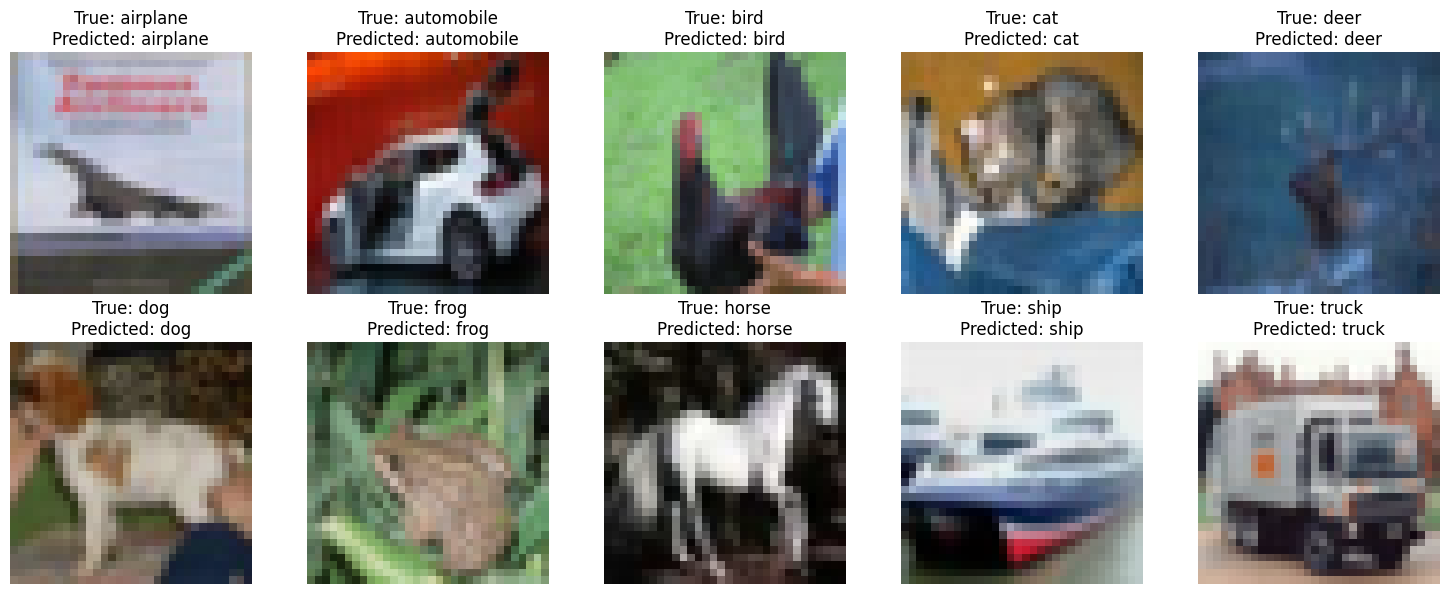

In [ ]:
# Retrieve the list of CIFAR-10 classes
cifar10_classes = train_dataset.classes if hasattr(train_dataset, "classes") else [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]

# Find one index per class in the test dataset
class_to_index = {}  # Dictionary to store one sample index per class
for idx, (image, label) in enumerate(test_dataset):
    if label not in class_to_index:  # Store only the first occurrence of each class
        class_to_index[label] = idx
    if len(class_to_index) == len(cifar10_classes):  # Stop when all classes are covered
        break

# Display one image for each of the 10 classes
fig, axs = plt.subplots(2, 5, figsize=(15, 6))  # Create a 2x5 grid for visualization
axs = axs.flatten()  # Flatten the grid for easy iteration

# Iterate over classes in ascending order (0 -> 9)
for i, label in enumerate(sorted(class_to_index.keys())):
    index = class_to_index[label]  # Get the index of an image from the current class
    image, true_label = test_dataset[index]  # Retrieve the image and its true label

    predicted_idx = predict_image(image, model, feature_extractor, device)  # Get model prediction
    predicted_class = cifar10_classes[predicted_idx]  # Convert prediction index to class name
    true_class = cifar10_classes[true_label]  # Convert true label index to class name

    axs[i].imshow(image)
    axs[i].set_title(f"True: {true_class}\nPredicted: {predicted_class}")
    axs[i].axis("off")
plt.tight_layout()
plt.show()


These results show that the ViT model correctly predicted the 10 classes present in the CIFAR-10 dataset. This demonstrates and confirms the model's performance observed during fine-tuning, indicating that it is a robust model for predicting CIFAR-10 classes, although it is not perfect and may potentially make mistakes by confusing certain classes, such as Airplane with Bird, for example. Finally, the displayed images appear "blurry," which is normal because the CIFAR-10 images have a very low resolution (32 × 32 pixels), and enlarging them for display makes them pixelated and less sharp.

## Part 4: Reflection and Discussion

Discussion Points:
1. What are the differences in how Transformers process text versus images?  
   Transformers process text by converting tokens into embeddings enriched with positional information to maintain sequential order, whereas for images, the approach involves dividing the image into linearized patches, each assigned a suitable positional embedding to preserve spatial structure.
2. How does the self-attention mechanism adapt to different data modalities?  
   The self-attention mechanism evaluates the similarities between all elements of a sequence whether words or image patches and adapts by incorporating context specific features of each modality, enabling the extraction of complex and relevant dependencies.
3. What are the limitations of Transformers, and how can they be mitigated?  
   Main limitations include quadratic complexity with respect to sequence length, heavy reliance on large volumes of data for optimal training, and sensitivity to initial biases; these challenges can be mitigated by using approximate attention techniques, pre-training on diverse corpora, and integrating hybrid mechanisms such as convolutional layers to better capture local structures.